<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_PyTorchTraining/blob/main/IG_PedObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell

wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2023-06-22 13:45:42--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  22.0MB/s    in 2.3s    

2023-06-22 13:45:44 (22.0 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-06-22 13:45:44--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-06-22 13:45:44--
Total wall clock time: 2.7s
Downloaded: 1 files, 51M in 2.3s (22.0 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [1]:
from PIL import Image

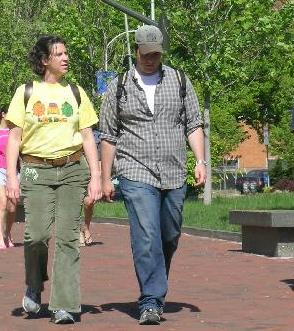

In [2]:
Image.open("PennFudanPed/PNGImages/PennPed00096.png")

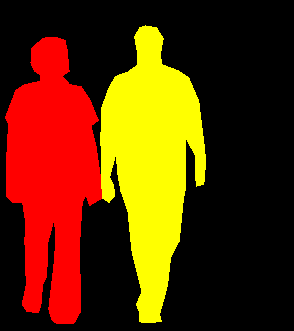

In [3]:
mask = Image.open("PennFudanPed/PedMasks/PennPed00096_mask.png")
mask = mask.convert('P')
mask.putpalette([
    0,0,0,
    255,0,0,
    255,255,0,
    255,150,0
])

mask

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

In [5]:
root_dir = "PennFudanPed"

In [6]:
os.path.join(root_dir, "PNGImages")

'PennFudanPed/PNGImages'

In [7]:
sorted(os.listdir(os.path.join(root_dir, "PNGImages")))[:5]

['FudanPed00001.png',
 'FudanPed00002.png',
 'FudanPed00003.png',
 'FudanPed00004.png',
 'FudanPed00005.png']

In [8]:
# images = sorted(os.listdir(os.path.join(root_dir, "PNGImages")))
# masks = sorted(os.listdir(os.path.join(root_dir, "PedMasks")))

In [9]:
# images[0]

In [10]:
# os.path.join(root_dir, "PNGImages", images[0])

In [11]:
# mask_img = os.path.join(root_dir, "PedMasks", masks[2])

In [12]:
# mask_img = Image.open(mask_img)

In [13]:
# mask_img = np.array(mask_img)

In [14]:
# mask_img.shape

In [15]:
# obj_id = np.unique(mask_img)

In [16]:
# mask_img

In [17]:
# obj_id = obj_id[1:]

In [18]:
# obj_id

In [19]:
# masks = mask_img == obj_id[:, None, None]

In [20]:
# masks

In [21]:
# masks.shape

In [22]:
# pos = np.nonzero(masks[0])

In [23]:
# pos[0].shape

In [24]:
# np.min(pos[0])

In [25]:
# torch.ones((2,), dtype=torch.int64)

In [90]:
import cv2

class PedDataset(Dataset):
  def __init__(self, root_dir, transforms=None):
    self.root_dir = root_dir
    self.transforms = transforms

    self.images = list(sorted(os.listdir(os.path.join(root_dir, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root_dir, "PedMasks"))))

  def __getitem__(self, index):
    flag = True
    img_path = os.path.join(self.root_dir, "PNGImages", self.images[index])
    mask_path = os.path.join(self.root_dir, "PedMasks", self.masks[index])
    # Read image using PIL Image package
    img = Image.open(img_path).convert("RGB")
    # read mask image
    mask = Image.open(mask_path)
    # convert PIL image into numpy array
    mask = np.array(mask)
    mask = cv2.resize(mask, (380, 423))
    obj_ids = np.unique(mask)
    # exclude 0th index, because 0th index is background color
    obj_ids = obj_ids[1:]
    # get binary mask only...
    # now it will set our mask image as either true or false
    masks = mask == obj_ids[:, None, None]
    target = {}
    # get bounding box
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      try:
        print("I is :",i, num_objs, masks.shape, index)
        pos = np.nonzero(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
      except BaseException as ex:
        print(ex)

    # type cast box list into a tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    # type cast mask into tensor
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["is_crowd"] = iscrowd

    if self.transforms:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.images)

In [27]:
# FasterRCNN (Object Detection) + MaskRCNN (Segmentation)

In [28]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [29]:
# FastRCNN is pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [30]:
NUM_CLASSES = 2
# number of input features for classifier
input_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(input_features, NUM_CLASSES)

In [31]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [32]:
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# mobilenet output channel is 1280

backbone.out_channels = 1280

anchor_gen = AnchorGenerator()
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7, sampling_ratio=2)
model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_gen,
                   box_roi_pool=roi_pooler)

In [33]:
# Instance Segmentation

In [34]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [35]:
def get_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
  input_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(input_features, NUM_CLASSES)

  input_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(input_features_mask,
                                                     hidden_layer,
                                                     NUM_CLASSES)
  return model

In [36]:
# import torchvision.transforms as T
import transforms as T

In [91]:
def transformations(train):
  transforms = []
  transforms.append(T.PILToTensor())
  transforms.append(T.ConvertImageDtype(torch.float))
  # transforms.append(T.Resize(300,300))
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [92]:
# %%shell
# git clone https://github.com/pytorch/vision.git

# cd vision
# cp references/detection/utils.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/coco_utils.py ../
# cp references/detection/transforms.py ../

In [93]:
from engine import train_one_epoch, evaluate
import utils

In [94]:
dataset = PedDataset(root_dir, transformations(train=True))
test_dataset = PedDataset(root_dir, transformations(train=False))

In [95]:
indices = torch.randperm(len(dataset)).tolist()

In [96]:
indices[:5]

[26, 167, 24, 164, 109]

In [97]:
len(indices)

170

In [98]:
# in train_dataset we have 170-50 = 120 images
train_dataset = torch.utils.data.Subset(dataset, indices[:-50])
# in test_dataset we have 50 images
test_dataset = torch.utils.data.Subset(test_dataset, indices[-50:])

In [99]:
data_loader_train = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=False
)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=False
)

In [100]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_segmentation(NUM_CLASSES)
model.to(device)

params = [param for param in model.parameters() if param.requires_grad]

optimizer = torch.optim.Adam(params, lr=0.003)

In [101]:
epochs = 10

for epoch in range(epochs):
  train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
  evaluate(model, data_loader_test, device=device)

I is : 0 1 (1, 423, 380) 26
I is : 0 1 (1, 423, 380) 167
I is : 0 6 (6, 423, 380) 24
I is : 1 6 (6, 423, 380) 24
I is : 2 6 (6, 423, 380) 24
I is : 3 6 (6, 423, 380) 24
I is : 4 6 (6, 423, 380) 24
I is : 5 6 (6, 423, 380) 24
I is : 0 1 (1, 423, 380) 164


RuntimeError: ignored

In [213]:
# len(train_dataset[0])

In [212]:
# len(train_dataset[2])

In [79]:
for i in range(len(train_dataset)):
  print(i)
  train_dataset[i]

0
I is : 0 3 (3, 423, 380) 94
I is : 1 3 (3, 423, 380) 94
I is : 2 3 (3, 423, 380) 94
1
I is : 0 3 (3, 423, 380) 6
I is : 1 3 (3, 423, 380) 6
I is : 2 3 (3, 423, 380) 6
2
I is : 0 1 (1, 423, 380) 16
3
I is : 0 1 (1, 423, 380) 23
4
I is : 0 2 (2, 423, 380) 169
I is : 1 2 (2, 423, 380) 169
5
I is : 0 3 (3, 423, 380) 119
I is : 1 3 (3, 423, 380) 119
I is : 2 3 (3, 423, 380) 119
6
I is : 0 3 (3, 423, 380) 146
I is : 1 3 (3, 423, 380) 146
I is : 2 3 (3, 423, 380) 146
7
I is : 0 1 (1, 423, 380) 51
8
I is : 0 1 (1, 423, 380) 167
9
I is : 0 2 (2, 423, 380) 39
I is : 1 2 (2, 423, 380) 39
10
I is : 0 2 (2, 423, 380) 5
I is : 1 2 (2, 423, 380) 5
11
I is : 0 3 (3, 423, 380) 88
I is : 1 3 (3, 423, 380) 88
I is : 2 3 (3, 423, 380) 88
12
I is : 0 2 (2, 423, 380) 49
I is : 1 2 (2, 423, 380) 49
13
I is : 0 4 (4, 423, 380) 47
I is : 1 4 (4, 423, 380) 47
I is : 2 4 (4, 423, 380) 47
I is : 3 4 (4, 423, 380) 47
14
I is : 0 1 (1, 423, 380) 97
15
I is : 0 2 (2, 423, 380) 143
I is : 1 2 (2, 423, 380) 143
16
I